# W266 Final Project

Authors: Satheesh Joseph, Catherine Mou, Yi Zhang

# Part 1: Downloading and preparing the data

We acquired the dataset from the researchers in the form of Sqlite `.db` files.

In [1]:
# Imports
import os, sys, re, json, time, unittest
import itertools, collections
from importlib import reload
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime

import numpy as np
from scipy import stats
import pandas as pd
import sqlite3
import unicodedata
import nltk

import tensorflow as tf
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, InputLayer, Embedding
from tensorflow.keras.layers import TextVectorization
import tensorflow_text as text  # Registers the ops.

from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_hub as hub

import tensorflow.keras as keras
from tensorflow.python.keras import utils

In [2]:
# Download the files if they're not here
if 'data' not in os.listdir('.') or not os.listdir('data'):
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpHotelData.db -P data/')
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpResData.db -P data/')
    print('Data downloaded successfully!')
else:
    print('Already downloaded data')

Already downloaded data


In [3]:
# Load data from the database
con = sqlite3.connect('data/yelpHotelData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('review',), ('sqlite_stat1',), ('sqlite_stat2',), ('reviewer',), ('hotel',)]


In [4]:
# Reading from the hotels database
hotels_db = sqlite3.connect("data/yelpHotelData.db")
hotels = pd.read_sql_query("SELECT * FROM hotel", hotels_db)
hotel_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", hotels_db)
hotel_reviewers = pd.read_sql_query("SELECT * FROM reviewer", hotels_db)

print(f'The data set contains {len(hotel_reviews)} reviews, and {len(hotel_reviewers)} reviewers')

The data set contains 5858 reviews, and 5123 reviewers


In [5]:
# Data Cleaning
hotel_reviews['reviewContent'] = hotel_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
hotel_reviews['date'] = hotel_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))


In [6]:
# Split data according to the research paper, i.e. balanced new reviews after 2012-01-01
hotel_X_test = hotel_reviews[hotel_reviews['date'] >= datetime.datetime(2012, 1, 1)]
hotel_X_test = hotel_X_test.sort_values('date', ignore_index=True).groupby('reviewerID', as_index=False).first()
hotel_X_test_positive = hotel_X_test[hotel_X_test['flagged'] == 'Y']
hotel_X_test_negative = hotel_X_test[hotel_X_test['flagged'] == 'N']
hotel_X_test_balanced = pd.concat([hotel_X_test_positive, hotel_X_test_negative.sample(n=len(hotel_X_test_positive))], ignore_index=True)
hotel_X_test = hotel_X_test_balanced.sample(frac=1)
hotel_y_test = hotel_X_test['flagged'] == 'Y'
hotel_X_train_and_dev = hotel_reviews[hotel_reviews['date'] < datetime.datetime(2012, 1, 1)]
hotel_X_train, hotel_X_dev, hotel_y_train, hotel_y_dev = train_test_split(hotel_X_train_and_dev, hotel_X_train_and_dev['flagged']=='Y')


# Part 2: Exploratory Data Analysis

In [7]:
hotel_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3402 entries, 217 to 4344
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3402 non-null   datetime64[ns]
 1   reviewID       3402 non-null   object        
 2   reviewerID     3402 non-null   object        
 3   reviewContent  3402 non-null   object        
 4   rating         3402 non-null   int64         
 5   usefulCount    3402 non-null   int64         
 6   coolCount      3402 non-null   int64         
 7   funnyCount     3402 non-null   int64         
 8   flagged        3402 non-null   object        
 9   hotelID        3402 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 292.4+ KB


In [8]:
reviews = hotel_X_train
reviews.groupby('reviewerID').agg({"usefulCount": np.sum, 
                                   "coolCount": np.sum, 
                                   "funnyCount": np.sum}).sort_values(by=['usefulCount'], ascending=False)
print(reviews[reviews['reviewerID'] == 'w-w-k-QXosIKQ8HQVwU6IQ']['reviewContent'].iloc[0])

***While the rooms are small, Hotel Felix is a nice hotel with modern and fresh decor, comfortable beds, clean rooms, good room temperature, and good showers; all these advantages plus their very good location make this one to definitely consider if you can get a competitive room rate*** Hotel Felix is an eco-friendly (Silver LEED certification) boutique hotel that has a convenient location in River North.  It is close to one of the subway lines as well as many well-known Chicago restaurants (Ria, Graham Elliot, Rick Bayless' spots) and The Magnificent Mile.  A lot of Chicago is walk-able and staying at Hotel Felix makes the walking part even easier. The hotel exterior (an older, renovated building) stands out with its huge (but not garish) sign.  The inside of the hotel is small--from the elevators to the lobby to the rooms.  I thought my room, which was on the top floor was actually not too small (maybe bigger than what some of the other reviewers had) and provided a decent view of s

In [9]:
reviews.groupby('flagged').agg('sum')

,rating,usefulCount,coolCount,funnyCount
flagged,,,,
N,10671,3713,1963,1665
Y,1398,0,0,0


,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,hotelID
rating,,,,,,,,,
1,205,205,205,205,205,205,205,205,205
2,327,327,327,327,327,327,327,327,327
3,609,609,609,609,609,609,609,609,609
4,1185,1185,1185,1185,1185,1185,1185,1185,1185
5,649,649,649,649,649,649,649,649,649


(array([ 205.,    0.,  327.,    0.,    0.,  609.,    0., 1185.,    0.,
         649.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

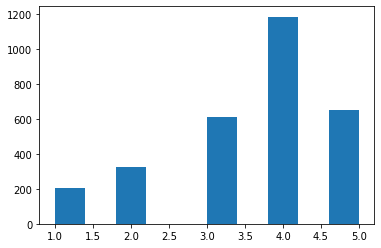

In [10]:
trueReviews = reviews[reviews['flagged'] == 'N']
fakeReviews = reviews[reviews['flagged'] == 'Y']
display(trueReviews.groupby('rating').agg('count'))
plt.hist(x=trueReviews.rating, bins=10)

,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,hotelID
rating,,,,,,,,,
1,93,93,93,93,93,93,93,93,93
2,64,64,64,64,64,64,64,64,64
3,37,37,37,37,37,37,37,37,37
4,99,99,99,99,99,99,99,99,99
5,134,134,134,134,134,134,134,134,134


(array([ 93.,   0.,  64.,   0.,   0.,  37.,   0.,  99.,   0., 134.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

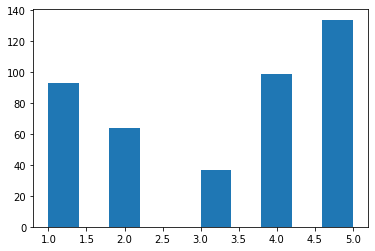

In [11]:
display(fakeReviews.groupby('rating').agg('count'))
plt.hist(x=fakeReviews.rating, bins=10)

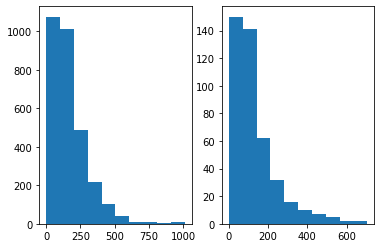

In [12]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count(' ') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count(' ') + 1)
plt.show()

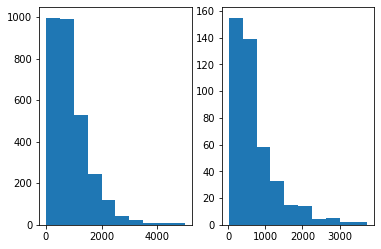

In [13]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count('.') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count('.') + 1)
plt.show()

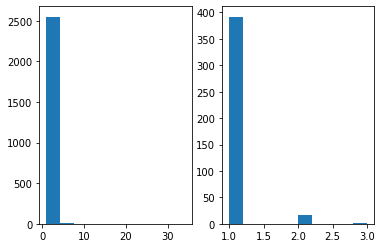

In [14]:
trueReviewerCounts = trueReviews.groupby(['reviewerID']).size().reset_index(name='counts')
fakeReviewerCounts = fakeReviews.groupby(['reviewerID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueReviewerCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviewerCounts['counts'], bins=10)
plt.show()


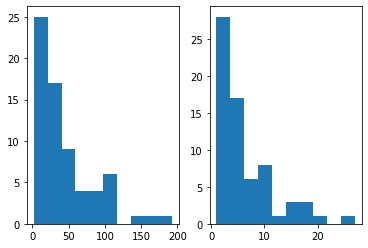

In [15]:
trueRestReviewCounts = trueReviews.groupby(['hotelID']).size().reset_index(name='counts')
fakeRestReviewCounts = fakeReviews.groupby(['hotelID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueRestReviewCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeRestReviewCounts['counts'], bins=10)
plt.show()


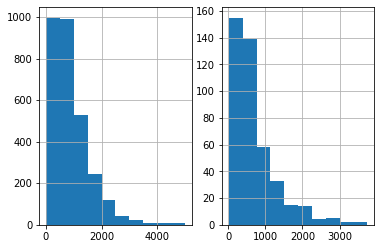

In [16]:
plt.subplot(1, 2, 1)
trueReviews['reviewContent'].str.len().hist()
plt.subplot(1, 2, 2)
fakeReviews['reviewContent'].str.len().hist()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


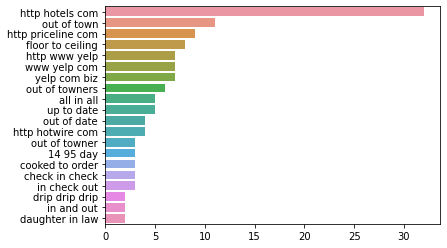

In [17]:
# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

nltk.download('stopwords')

def plot_top_ngrams_barchart(text, n=2):
    synthetic = {'gmail', 'they', 'http', 'www'}
    stop=set(stopwords.words('english')) | synthetic
    new= text.str.split()
    new= new.values.tolist()
    corpus=[word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(corpus,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    

plot_top_ngrams_barchart(trueReviews['reviewContent'],3)

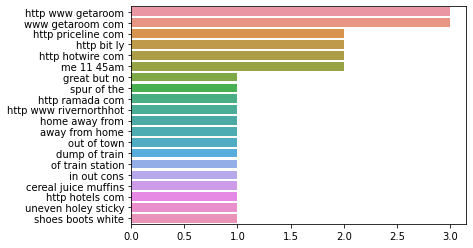

In [18]:
plot_top_ngrams_barchart(fakeReviews['reviewContent'],3)

In [19]:
fake_df = hotel_reviews[hotel_reviews['flagged'] == 'Y']["reviewerID"].to_frame()
true_df = hotel_reviews[hotel_reviews['flagged'] == 'N']["reviewerID"].to_frame()
print("Fake Reviewers " + str(len(fake_df["reviewerID"].unique())))
print("True Reviewers " + str(len(true_df["reviewerID"].unique())))
print("True and Fake Reviewers " + str(len(list(set(fake_df["reviewerID"].unique()) & set(true_df["reviewerID"].unique())))))

Fake Reviewers 751
True Reviewers 4277
True and Fake Reviewers 0


In [20]:
full_rest_df = pd.merge(hotel_reviews, hotel_reviewers, on="reviewerID")
fake_df = full_rest_df[full_rest_df['flagged'] == 'Y']["firstCount"]
true_df = full_rest_df[full_rest_df['flagged'] == 'N']["firstCount"]
print("Fake stats Counts " + str(fake_df.count()) + str(" Sum ") + str(fake_df.sum()))
print("True stats Counts " + str(true_df.count()) + str(" Sum ") + str(true_df.sum()))

Fake stats Counts 777 Sum 486
True stats Counts 5072 Sum 144161


# Part 3: Model Training

## Preparing for the word embeddings

In [21]:
# GloVe Embeddings
# Download the GloVe embeddings
if 'embedding' not in os.listdir('.') or not os.listdir('embedding'):
    os.system('wget http://nlp.stanford.edu/data/glove.6B.zip -P embedding/')
    os.system('cd embedding && unzip glove.6B.zip')
    print('Data the GloVe embedding successfully!')
else:
    print('Already downloaded the embedding')
    
# Use the 100 dimensional GloVe embedding
path_to_glove_file = "./embedding/glove.6B.200d.txt"

glove_dimension = 200
glove_embedding_map = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embedding_map[word] = coefs

print("Found %s word vectors." % len(glove_embedding_map))

def get_glove_embedding(word):
    return glove_embedding_map.get(word.strip(), None)


Already downloaded the embedding
Found 400000 word vectors.


In [22]:
# Pre-trained Elmo
elmo = hub.load("https://tfhub.dev/google/elmo/3")

def get_elmo_embedding(words):
    return elmo.signatures['default'](tf.constant(words))['elmo']


2021-11-27 21:54:55.488888: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model 1: GloVe Embedding + Plain LSTM

In [23]:
def build_model_1_hotel(num_epochs=2, sequence_length=100):
    
    # First layer, vectorizing the word input
    m1_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m1_hotel_vectorizer.adapt(hotel_X_train['reviewContent'].to_numpy())
    m1_hotel_voc = m1_hotel_vectorizer.get_vocabulary()

    print(f"Model 1: Hotels reviews vocabulary size is {len(m1_hotel_voc)}")

    # Build + Lock in the Embedding layer from GloVe
    # Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
    hits = 0
    misses = 0
    num_words = len(m1_hotel_voc)

    # Prepare embedding matrix
    m1_hotel_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m1_hotel_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m1_hotel_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m1_hotel_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m1_hotel_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    hotel_X_train_ready = m1_hotel_vectorizer(hotel_X_train['reviewContent']).numpy()
    hotel_X_dev_ready = m1_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m1_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_1_hotel')
    model.add(m1_hotel_embedding_layer)
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))


In [24]:
for sequence_length in [100, 300, 500, None]:
    print(f"Start training with sequence_length={sequence_length}")
    build_model_1_hotel(num_epochs=10, sequence_length=sequence_length)

Start training with sequence_length=100
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (3402, 100)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         3832400   
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 3,900,305
Trainable params: 67,905
Non-trainable params: 3,832,400
_________________________________________________________________
None
Epoch 1/10
107/107 [==============================] - 9s 67ms/step - loss: 0.3993 - accuracy: 0.8668
Epoch 2/10
107/107 [===================

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=300
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (3402, 300)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         3832400   
                                                                 
 lstm_1 (LSTM)               (None, 64)                67840     
                                                                 
 dense_1 (Dense)     

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=500
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (3402, 500)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         3832400   
                                                                 
 lstm_2 (LSTM)               (None, 64)                67840     
                                                                 
 dense_2 (Dense)     

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=None
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (3402, 951)
Model: "model_1_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 200)         3832400   
                                                                 
 lstm_3 (LSTM)               (None, 64)                67840     
                                                                 
 dense_3 (Dense)    

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

## Model 2 - Data Resampling + GloVe Embedding + LSTM

In [25]:
# Split the positive/negative samples for more balanced sampling
hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

print(f'There are {len(hotel_X_train_positive)} positive examples')
print(f'There are {len(hotel_X_train_negative)} negative examples')

def build_model_2_hotel(num_epochs=2, sequence_length=50, resample_ratio=0.5):

    # First layer, vectorizing the word input
    m2_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m2_hotel_vectorizer.adapt(hotel_X_train['reviewContent'].to_numpy())
    m2_hotel_voc = m2_hotel_vectorizer.get_vocabulary()

    print(f"Model 1: Hotels reviews vocabulary size is {len(m2_hotel_voc)}")

    # Build + Lock in the Embedding layer from GloVe
    # Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
    hits = 0
    misses = 0
    num_words = len(m2_hotel_voc)

    # Prepare embedding matrix
    m2_hotel_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m2_hotel_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m2_hotel_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m2_hotel_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m2_hotel_embedding_matrix),
        trainable=False,
    )
    
    # Oversample some positive training samples
    num_negative_samples = len(hotel_X_train_negative)
    positive_ratio = resample_ratio
    hotel_positives = hotel_X_train_positive.sample(n=int(num_negative_samples * positive_ratio), replace=True).reset_index(drop=True)
    hotel_negatives = hotel_X_train_negative

    hotel_X_train_balanced = pd.concat([hotel_positives, hotel_negatives], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'
    
    # Vectorize the input
    hotel_X_train_ready = m2_hotel_vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
    hotel_X_dev_ready = m2_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m2_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_2_hotel')
    model.add(m2_hotel_embedding_layer)
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))
    

There are 427 positive examples
There are 2975 negative examples


In [26]:
for sequence_length in [100, 300, 500, None]:
    for resample_ratio in [0.25, 0.5, 0.75, 1]:
        print(f"Start training with sequence_length={sequence_length}, ratio={resample_ratio}")
        build_model_2_hotel(num_epochs=10, sequence_length=sequence_length, resample_ratio=resample_ratio)

Start training with sequence_length=100, ratio=0.25
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (3718, 100)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 200)         3832400   
                                                                 
 lstm_4 (LSTM)               (None, 128)               168448    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,000,977
Trainable params: 168,577
Non-trainable params: 3,832,400
_________________________________________________________________
None
Epoch 1/10
117/117 [==============================] - 13s 95ms/step - loss: 0.5020 - accuracy: 0.7977
Epoch 2/10
117/117 [=====

Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (5950, 100)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 200)         3832400   
                                                                 
 lstm_7 (LSTM)               (None, 128)               168448    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,000,977
Trainable params: 168,577
Non-trainable params: 3,832,400
_________________________________________________________________
None
Epoch 1/10
186/186 [==============================] - 20s 94ms/step - loss: 0.6609 - accuracy: 0.6087
Epoch 2/10
186/186 [==============================] - 18s 98ms/step - loss: 0

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=300, ratio=0.5
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (4462, 300)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 200)         3832400   
                                                                 
 lstm_9 (LSTM)               (None, 128)               168448    
                                                                 
 dense_9 (

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=300, ratio=0.75
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (5206, 300)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 200)         3832400   
                                                                 
 lstm_10 (LSTM)              (None, 128)               168448    
                                                                 
 dense_10

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=300, ratio=1
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (5950, 300)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 200)         3832400   
                                                                 
 lstm_11 (LSTM)              (None, 128)               168448    
                                                                 
 dense_11 (D

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=500, ratio=0.5
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (4462, 500)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 200)         3832400   
                                                                 
 lstm_13 (LSTM)              (None, 128)               168448    
                                                                 
 dense_13 

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=500, ratio=0.75
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (5206, 500)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 200)         3832400   
                                                                 
 lstm_14 (LSTM)              (None, 128)               168448    
                                                                 
 dense_14

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=500, ratio=1
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (5950, 500)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 200)         3832400   
                                                                 
 lstm_15 (LSTM)              (None, 128)               168448    
                                                                 
 dense_15 (D

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=None, ratio=0.25
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (3718, 951)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 200)         3832400   
                                                                 
 lstm_16 (LSTM)              (None, 128)               168448    
                                                                 
 dense_1

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=None, ratio=0.5
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (4462, 951)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, None, 200)         3832400   
                                                                 
 lstm_17 (LSTM)              (None, 128)               168448    
                                                                 
 dense_17

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=None, ratio=0.75
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (5206, 951)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 200)         3832400   
                                                                 
 lstm_18 (LSTM)              (None, 128)               168448    
                                                                 
 dense_1

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with sequence_length=None, ratio=1
Model 1: Hotels reviews vocabulary size is 19162
Converted 14613 words (4549 misses)
training set shape: (5950, 951)
Model: "model_2_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 200)         3832400   
                                                                 
 lstm_19 (LSTM)              (None, 128)               168448    
                                                                 
 dense_19 (

# Model 3: Train with generated fake reviews on LSTM

In [27]:
# Generating fake reviews from gpt-2 based on the training fake review set.
# Catherine ran it in an AWS instance and it takes a really long time.
# Commenting out the code to not run over and over again.
##########################
# !pip install transformers
# !pip install torch

# hotel_reviews_fake = hotel_X_train[hotel_X_train['flagged'] == 'Y']
# np.savetxt(r'data/hotel_fake.txt', hotel_reviews_fake['reviewContent'].values, fmt='%s')

# !python gpt2_fine_tuning.py \
#     --output_dir hotel \
#     --model_name_or_path=gpt2 \
#     --do_train \
#     --train_data_file='./data/hotel_fake.txt' \
#     --per_gpu_train_batch_size=1

# !python gpt2_generation.py \
#     --model_name_or_path hotel \
#     --length=10 \
#     --seed=3

In [28]:
# Load more generated fake reviews for model 3:
# Load in previous generated fake reviews
with open('final_GAN.txt') as f:
    lines = f.read().splitlines()
    lines = [l for l in lines if l]
    hotel_X_train_positive_generated = pd.DataFrame({'reviewContent':lines, 'flagged': 'Y'})

def build_model_3_hotel(num_units, num_epochs=2, sequence_length=None):

    # Add generated fake reviews into the training set
    hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
    hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

    print(f'There are {len(hotel_X_train_positive)} positive examples')
    print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(hotel_X_train_negative)} negative examples')

    hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated], ignore_index=True)

    num_samples = min(len(hotel_X_train_all_positive), len(hotel_X_train_negative))
    hotel_X_train_all_positive_sampled = hotel_X_train_all_positive.sample(n=num_samples)
    hotel_X_train_negative_sampled = hotel_X_train_negative.sample(n=num_samples)

    hotel_X_train_balanced = pd.concat([hotel_X_train_all_positive_sampled, hotel_X_train_negative_sampled], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(hotel_X_train_balanced['flagged'] == 'Y')} positive, {sum(hotel_X_train_balanced['flagged'] == 'N')} negative")

    # For model 3, have to re-do the embedding again:
    m3_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m3_hotel_vectorizer.adapt(hotel_X_train_balanced['reviewContent'].to_numpy())
    m3_hotel_voc = m3_hotel_vectorizer.get_vocabulary()
    print(f"Model 3: Hotels reviews vocabulary size is {len(m3_hotel_voc)}")

    # Build + Lock in the Embedding layer from GloVe again
    hits = 0
    misses = 0
    num_words = len(m3_hotel_voc)

    # Prepare embedding matrix
    m3_hotel_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m3_hotel_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m3_hotel_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m3_hotel_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m3_hotel_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    hotel_X_train_ready = m3_hotel_vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
    hotel_X_dev_ready = m3_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m3_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_3_hotel')
    model.add(m3_hotel_embedding_layer)
    model.add(Bidirectional(LSTM(num_units)))
    model.add(Dense(num_units//2, activation='relu'))
    model.add(Dense(num_units//4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the training set
    hotel_y_predicted_train = model.predict(hotel_X_train_ready)
    print(classification_report(hotel_y_predicted_train > 0.5, hotel_y_train_balanced))
    print('Training set class distribution')
    print(hotel_X_train['flagged'].value_counts() / len(hotel_X_train))

    # Evaluate on the dev set
    hotel_y_predicted_dev = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted_dev > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted_test = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted_test > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))


In [29]:
for num_units in [16, 32, 64, 128]:
    for num_epochs in [5, 10, 15]:
        for sequence_length in [100, 300, 500, None]:
            print(f"Start training with num_epochs={num_epochs}, sequence_length={sequence_length}")
            build_model_3_hotel(num_units=num_units, num_epochs=num_epochs, sequence_length=sequence_length)

Start training with num_epochs=5, sequence_length=100
There are 427 positive examples
There are 1974 generated positive examples
There are 2975 negative examples
Training samples: 2401 positive, 2401 negative
Model 3: Hotels reviews vocabulary size is 20600
Converted 15042 words (5558 misses)
training set shape: (4802, 100)
Model: "model_3_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 200)         4120000   
                                                                 
 bidirectional (Bidirectiona  (None, 32)               27776     
 l)                                                              
                                                                 
 dense_20 (Dense)            (None, 8)                 264       
                                                                 
 dense_21 (Dense)            (None, 4)                 36

151/151 [==============================] - 18s 122ms/step - loss: 0.6814 - accuracy: 0.5700
Epoch 4/5
151/151 [==============================] - 19s 125ms/step - loss: 0.6937 - accuracy: 0.5000
Epoch 5/5
151/151 [==============================] - 19s 125ms/step - loss: 0.6905 - accuracy: 0.5523
              precision    recall  f1-score   support

       False       0.23      0.71      0.35       778
        True       0.91      0.54      0.68      4024

    accuracy                           0.57      4802
   macro avg       0.57      0.63      0.51      4802
weighted avg       0.80      0.57      0.62      4802

Training set class distribution
N    0.874486
Y    0.125514
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.22      0.94      0.36       234
        True       0.90      0.13      0.23       900

    accuracy                           0.30      1134
   macro avg       0.56      0.54      0.29      1134
weighted avg   

Model 3: Hotels reviews vocabulary size is 20468
Converted 14971 words (5497 misses)
training set shape: (4802, 300)
Model: "model_3_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, None, 200)         4093600   
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               27776     
 nal)                                                            
                                                                 
 dense_35 (Dense)            (None, 8)                 264       
                                                                 
 dense_36 (Dense)            (None, 4)                 36        
                                                                 
 dense_37 (Dense)            (None, 1)                 5         
                                                                 
To

151/151 [==============================] - 38s 232ms/step - loss: 0.6918 - accuracy: 0.5239
Epoch 2/10
151/151 [==============================] - 37s 243ms/step - loss: 0.6848 - accuracy: 0.5560
Epoch 3/10
151/151 [==============================] - 36s 241ms/step - loss: 0.6609 - accuracy: 0.6091
Epoch 4/10
151/151 [==============================] - 36s 240ms/step - loss: 0.6091 - accuracy: 0.6766
Epoch 5/10
151/151 [==============================] - 36s 239ms/step - loss: 0.5676 - accuracy: 0.7116
Epoch 6/10
151/151 [==============================] - 36s 240ms/step - loss: 0.5217 - accuracy: 0.7486
Epoch 7/10
151/151 [==============================] - 36s 238ms/step - loss: 0.4903 - accuracy: 0.7672
Epoch 8/10
151/151 [==============================] - 36s 241ms/step - loss: 0.4645 - accuracy: 0.7980
Epoch 9/10
151/151 [==============================] - 36s 241ms/step - loss: 0.4269 - accuracy: 0.8182
Epoch 10/10
151/151 [==============================] - 36s 240ms/step - loss: 0.3897

Epoch 3/15
151/151 [==============================] - 11s 73ms/step - loss: 0.6515 - accuracy: 0.6141
Epoch 4/15
151/151 [==============================] - 11s 72ms/step - loss: 0.6176 - accuracy: 0.6576
Epoch 5/15
151/151 [==============================] - 12s 76ms/step - loss: 0.5753 - accuracy: 0.7074
Epoch 6/15
151/151 [==============================] - 11s 75ms/step - loss: 0.5329 - accuracy: 0.7334
Epoch 7/15
151/151 [==============================] - 12s 77ms/step - loss: 0.4757 - accuracy: 0.7820
Epoch 8/15
151/151 [==============================] - 11s 74ms/step - loss: 0.4307 - accuracy: 0.8036
Epoch 9/15
151/151 [==============================] - 11s 73ms/step - loss: 0.3849 - accuracy: 0.8340
Epoch 10/15
151/151 [==============================] - 11s 75ms/step - loss: 0.3432 - accuracy: 0.8584
Epoch 11/15
151/151 [==============================] - 11s 76ms/step - loss: 0.3079 - accuracy: 0.8744
Epoch 12/15
151/151 [==============================] - 12s 76ms/step - loss: 0.2

151/151 [==============================] - 38s 235ms/step - loss: 0.6914 - accuracy: 0.5229
Epoch 2/15
151/151 [==============================] - 36s 241ms/step - loss: 0.6813 - accuracy: 0.5671
Epoch 3/15
151/151 [==============================] - 37s 243ms/step - loss: 0.6631 - accuracy: 0.6027
Epoch 4/15
151/151 [==============================] - 36s 240ms/step - loss: 0.6349 - accuracy: 0.6433
Epoch 5/15
151/151 [==============================] - 36s 239ms/step - loss: 0.5979 - accuracy: 0.6870
Epoch 6/15
151/151 [==============================] - 36s 241ms/step - loss: 0.5507 - accuracy: 0.7239
Epoch 7/15
151/151 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.76 - 36s 240ms/step - loss: 0.5025 - accuracy: 0.7628
Epoch 8/15
151/151 [==============================] - 36s 241ms/step - loss: 0.4517 - accuracy: 0.8001
Epoch 9/15
151/151 [==============================] - 36s 240ms/step - loss: 0.4130 - accuracy: 0.8149
Epoch 10/15
151/151 [=====================

              precision    recall  f1-score   support

       False       0.67      0.93      0.78       717
        True       0.65      0.21      0.32       417

    accuracy                           0.67      1134
   macro avg       0.66      0.57      0.55      1134
weighted avg       0.66      0.67      0.61      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.60      0.54      0.57       241
        True       0.49      0.55      0.52       191

    accuracy                           0.54       432
   macro avg       0.54      0.54      0.54       432
weighted avg       0.55      0.54      0.55       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=500
There are 427 positive examples
There are 1974 generated positive examples
There are 2975 negative examples
Training samples: 2401 

151/151 [==============================] - 7s 27ms/step - loss: 0.6884 - accuracy: 0.5404
Epoch 2/10
151/151 [==============================] - 4s 27ms/step - loss: 0.6724 - accuracy: 0.5810
Epoch 3/10
151/151 [==============================] - 4s 27ms/step - loss: 0.6395 - accuracy: 0.6389
Epoch 4/10
151/151 [==============================] - 4s 25ms/step - loss: 0.5920 - accuracy: 0.6887
Epoch 5/10
151/151 [==============================] - 4s 25ms/step - loss: 0.5261 - accuracy: 0.7382
Epoch 6/10
151/151 [==============================] - 4s 25ms/step - loss: 0.4638 - accuracy: 0.7813
Epoch 7/10
151/151 [==============================] - 4s 25ms/step - loss: 0.3982 - accuracy: 0.8188
Epoch 8/10
151/151 [==============================] - 4s 25ms/step - loss: 0.3553 - accuracy: 0.8438
Epoch 9/10
151/151 [==============================] - 4s 28ms/step - loss: 0.2809 - accuracy: 0.8882
Epoch 10/10
151/151 [==============================] - 4s 27ms/step - loss: 0.2224 - accuracy: 0.9155


151/151 [==============================] - 20s 132ms/step - loss: 0.4759 - accuracy: 0.7763
Epoch 9/10
151/151 [==============================] - 21s 136ms/step - loss: 0.4191 - accuracy: 0.8142
Epoch 10/10
151/151 [==============================] - 20s 131ms/step - loss: 0.3600 - accuracy: 0.8457
              precision    recall  f1-score   support

       False       0.91      0.89      0.90      2448
        True       0.89      0.91      0.90      2354

    accuracy                           0.90      4802
   macro avg       0.90      0.90      0.90      4802
weighted avg       0.90      0.90      0.90      4802

Training set class distribution
N    0.874486
Y    0.125514
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.73      0.95      0.83       772
        True       0.70      0.26      0.38       362

    accuracy                           0.73      1134
   macro avg       0.72      0.60      0.60      1134
weighted avg

Epoch 15/15
151/151 [==============================] - 4s 26ms/step - loss: 0.0575 - accuracy: 0.9819
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      2393
        True       0.99      0.99      0.99      2409

    accuracy                           0.99      4802
   macro avg       0.99      0.99      0.99      4802
weighted avg       0.99      0.99      0.99      4802

Training set class distribution
N    0.874486
Y    0.125514
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.75      0.96      0.84       782
        True       0.77      0.29      0.42       352

    accuracy                           0.75      1134
   macro avg       0.76      0.63      0.63      1134
weighted avg       0.76      0.75      0.71      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False  

151/151 [==============================] - 20s 130ms/step - loss: 0.2836 - accuracy: 0.8859
Epoch 12/15
151/151 [==============================] - 20s 133ms/step - loss: 0.2305 - accuracy: 0.9161
Epoch 13/15
151/151 [==============================] - 20s 134ms/step - loss: 0.2090 - accuracy: 0.9223
Epoch 14/15
151/151 [==============================] - 20s 130ms/step - loss: 0.1633 - accuracy: 0.9436
Epoch 15/15
151/151 [==============================] - 20s 136ms/step - loss: 0.1464 - accuracy: 0.9509
              precision    recall  f1-score   support

       False       0.95      0.98      0.97      2327
        True       0.98      0.95      0.97      2475

    accuracy                           0.97      4802
   macro avg       0.97      0.97      0.97      4802
weighted avg       0.97      0.97      0.97      4802

Training set class distribution
N    0.874486
Y    0.125514
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0

              precision    recall  f1-score   support

       False       0.80      0.94      0.86       850
        True       0.62      0.29      0.40       284

    accuracy                           0.78      1134
   macro avg       0.71      0.62      0.63      1134
weighted avg       0.75      0.78      0.75      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.75      0.53      0.62       309
        True       0.32      0.57      0.41       123

    accuracy                           0.54       432
   macro avg       0.54      0.55      0.52       432
weighted avg       0.63      0.54      0.56       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5, sequence_length=300
There are 427 positive examples
There are 1974 generated positive examples
There are 2975 negative examples
Training samples: 2401 

151/151 [==============================] - 61s 383ms/step - loss: 0.6897 - accuracy: 0.5314
Epoch 2/5
151/151 [==============================] - 59s 390ms/step - loss: 0.6794 - accuracy: 0.5664
Epoch 3/5
151/151 [==============================] - 59s 392ms/step - loss: 0.6498 - accuracy: 0.6249
Epoch 4/5
151/151 [==============================] - 59s 390ms/step - loss: 0.6092 - accuracy: 0.6722
Epoch 5/5
151/151 [==============================] - 60s 396ms/step - loss: 0.5552 - accuracy: 0.7205
              precision    recall  f1-score   support

       False       0.85      0.70      0.77      2899
        True       0.64      0.81      0.72      1903

    accuracy                           0.74      4802
   macro avg       0.74      0.76      0.74      4802
weighted avg       0.77      0.74      0.75      4802

Training set class distribution
N    0.874486
Y    0.125514
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.77     

              precision    recall  f1-score   support

       False       0.83      0.95      0.89       880
        True       0.65      0.34      0.45       254

    accuracy                           0.81      1134
   macro avg       0.74      0.64      0.67      1134
weighted avg       0.79      0.81      0.79      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.80      0.55      0.65       311
        True       0.36      0.64      0.46       121

    accuracy                           0.58       432
   macro avg       0.58      0.59      0.55       432
weighted avg       0.67      0.58      0.60       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10, sequence_length=500
There are 427 positive examples
There are 1974 generated positive examples
There are 2975 negative examples
Training samples: 2401

Model 3: Hotels reviews vocabulary size is 20372
Converted 14911 words (5461 misses)
training set shape: (4802, 100)
Model: "model_3_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, None, 200)         4074400   
                                                                 
 bidirectional_32 (Bidirecti  (None, 128)              135680    
 onal)                                                           
                                                                 
 dense_116 (Dense)           (None, 32)                4128      
                                                                 
 dense_117 (Dense)           (None, 16)                528       
                                                                 
 dense_118 (Dense)           (None, 1)                 17        
                                                                 
To

Model 3: Hotels reviews vocabulary size is 20570
Converted 15027 words (5543 misses)
training set shape: (4802, 500)
Model: "model_3_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, None, 200)         4114000   
                                                                 
 bidirectional_34 (Bidirecti  (None, 128)              135680    
 onal)                                                           
                                                                 
 dense_122 (Dense)           (None, 32)                4128      
                                                                 
 dense_123 (Dense)           (None, 16)                528       
                                                                 
 dense_124 (Dense)           (None, 1)                 17        
                                                                 
To

Model 3: Hotels reviews vocabulary size is 20625
Converted 15114 words (5511 misses)
training set shape: (4802, 100)
Model: "model_3_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, None, 200)         4125000   
                                                                 
 bidirectional_36 (Bidirecti  (None, 256)              336896    
 onal)                                                           
                                                                 
 dense_128 (Dense)           (None, 64)                16448     
                                                                 
 dense_129 (Dense)           (None, 32)                2080      
                                                                 
 dense_130 (Dense)           (None, 1)                 33        
                                                                 
To

151/151 [==============================] - 51s 338ms/step - loss: 0.4742 - accuracy: 0.7747
              precision    recall  f1-score   support

       False       0.82      0.85      0.84      2326
        True       0.85      0.83      0.84      2476

    accuracy                           0.84      4802
   macro avg       0.84      0.84      0.84      4802
weighted avg       0.84      0.84      0.84      4802

Training set class distribution
N    0.874486
Y    0.125514
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.70      0.95      0.80       734
        True       0.72      0.24      0.36       400

    accuracy                           0.70      1134
   macro avg       0.71      0.60      0.58      1134
weighted avg       0.71      0.70      0.65      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64
              precision    recall  f1-score   support

       False       0.66 

Model 3: Hotels reviews vocabulary size is 20456
Converted 14979 words (5477 misses)
training set shape: (4802, 300)
Model: "model_3_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_61 (Embedding)    (None, None, 200)         4091200   
                                                                 
 bidirectional_41 (Bidirecti  (None, 256)              336896    
 onal)                                                           
                                                                 
 dense_143 (Dense)           (None, 64)                16448     
                                                                 
 dense_144 (Dense)           (None, 32)                2080      
                                                                 
 dense_145 (Dense)           (None, 1)                 33        
                                                                 
To

151/151 [==============================] - 102s 655ms/step - loss: 0.6915 - accuracy: 0.5275
Epoch 2/10
151/151 [==============================] - 100s 660ms/step - loss: 0.6822 - accuracy: 0.5633
Epoch 3/10
151/151 [==============================] - 100s 662ms/step - loss: 0.6468 - accuracy: 0.6204
Epoch 4/10
151/151 [==============================] - 99s 659ms/step - loss: 0.5848 - accuracy: 0.6866
Epoch 5/10
151/151 [==============================] - 99s 657ms/step - loss: 0.5095 - accuracy: 0.7428
Epoch 6/10
151/151 [==============================] - 100s 661ms/step - loss: 0.4086 - accuracy: 0.8174
Epoch 7/10
151/151 [==============================] - 99s 656ms/step - loss: 0.3321 - accuracy: 0.8553
Epoch 8/10
151/151 [==============================] - 99s 658ms/step - loss: 0.2578 - accuracy: 0.8932
Epoch 9/10
151/151 [==============================] - 99s 657ms/step - loss: 0.1915 - accuracy: 0.9250
Epoch 10/10
151/151 [==============================] - 99s 656ms/step - loss: 0.

151/151 [==============================] - 31s 203ms/step - loss: 0.6628 - accuracy: 0.5960
Epoch 3/15
151/151 [==============================] - 31s 204ms/step - loss: 0.6117 - accuracy: 0.6549
Epoch 4/15
151/151 [==============================] - 30s 201ms/step - loss: 0.5430 - accuracy: 0.7226
Epoch 5/15
151/151 [==============================] - 31s 205ms/step - loss: 0.4520 - accuracy: 0.7845
Epoch 6/15
151/151 [==============================] - 30s 200ms/step - loss: 0.3686 - accuracy: 0.8357
Epoch 7/15
151/151 [==============================] - 31s 204ms/step - loss: 0.2959 - accuracy: 0.8730
Epoch 8/15
151/151 [==============================] - 31s 203ms/step - loss: 0.2157 - accuracy: 0.9132
Epoch 9/15
151/151 [==============================] - 30s 197ms/step - loss: 0.1529 - accuracy: 0.9409
Epoch 10/15
151/151 [==============================] - 31s 207ms/step - loss: 0.1076 - accuracy: 0.9584
Epoch 11/15
151/151 [==============================] - 30s 198ms/step - loss: 0.077

151/151 [==============================] - 102s 652ms/step - loss: 0.6939 - accuracy: 0.5179
Epoch 2/15
151/151 [==============================] - 99s 655ms/step - loss: 0.6765 - accuracy: 0.5810
Epoch 3/15
151/151 [==============================] - 99s 655ms/step - loss: 0.6467 - accuracy: 0.6341
Epoch 4/15
151/151 [==============================] - 100s 665ms/step - loss: 0.5874 - accuracy: 0.6868
Epoch 5/15
151/151 [==============================] - 99s 657ms/step - loss: 0.4885 - accuracy: 0.7628
Epoch 6/15
151/151 [==============================] - 100s 659ms/step - loss: 0.3994 - accuracy: 0.8265
Epoch 7/15
151/151 [==============================] - 99s 653ms/step - loss: 0.3556 - accuracy: 0.8438
Epoch 8/15
151/151 [==============================] - 99s 656ms/step - loss: 0.2812 - accuracy: 0.8838
Epoch 9/15
151/151 [==============================] - 99s 656ms/step - loss: 0.2148 - accuracy: 0.9180
Epoch 10/15
151/151 [==============================] - 99s 653ms/step - loss: 0.2

# Model 4: Training with generated fake reviews on BERT

In [30]:
# Train BERT
import tensorflow_text as text 
def build_model_4_hotel(num_units, num_epochs=1):
    
    # Add generated fake reviews into the training set
    hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
    hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

    print(f'There are {len(hotel_X_train_positive)} positive examples')
    print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(hotel_X_train_negative)} negative examples')

    hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated], ignore_index=True)

    num_samples = min(len(hotel_X_train_all_positive), len(hotel_X_train_negative))
    hotel_X_train_all_positive_sampled = hotel_X_train_all_positive.sample(n=num_samples)
    hotel_X_train_negative_sampled = hotel_X_train_negative.sample(n=num_samples)

    hotel_X_train_balanced = pd.concat([hotel_X_train_all_positive_sampled, hotel_X_train_negative_sampled], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(hotel_X_train_balanced['flagged'] == 'Y')} positive, {sum(hotel_X_train_balanced['flagged'] == 'N')} negative")

    # BERT has its own input and preprocessing
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1", trainable=True)
    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = Dropout(0.2)(net)
    net = Dense(num_units, activation='relu')(net)
    net = Dense(1, activation='sigmoid')(net)
    model = tf.keras.Model(text_input, net)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    model.fit(hotel_X_train_balanced['reviewContent'], hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev['reviewContent'])
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test['reviewContent'])
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))


In [31]:
for num_units in [16, 32, 64]:
    for num_epochs in [5, 10]:
        print(f"Start training with num_epochs={num_epochs}")
        build_model_4_hotel(num_units=num_units, num_epochs=num_epochs)

Start training with num_epochs=5
There are 427 positive examples
There are 1974 generated positive examples
There are 2975 negative examples
Training samples: 2401 positive, 2401 negative
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
     

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.12      0.21      1134

    accuracy                           0.12      1134
   macro avg       0.50      0.06      0.11      1134
weighted avg       1.00      0.12      0.21      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.50      0.67       432

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10
There are 427 positive examples
There are 1974 generated positive examples
There are 2975 negative examples
Training samples: 2401 positive, 2401 negative
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5
There are 427 positive examples
There are 1974 generated positive examples
There are 2975 negative examples
Training samples: 2401 positive, 2401 negative
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                               

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with num_epochs=10
There are 427 positive examples
There are 1974 generated positive examples
There are 2975 negative examples
Training samples: 2401 positive, 2401 negative
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      1134
        True       0.00      0.00      0.00         0

    accuracy                           0.88      1134
   macro avg       0.50      0.44      0.47      1134
weighted avg       1.00      0.88      0.94      1134

Dev set class distribution
N    0.881834
Y    0.118166
Name: flagged, dtype: float64


/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
Start training with num_epochs=5
There are 427 positive examples
There are 1974 generated positive examples
There are 2975 negative examples
Training samples: 2401 positive, 2401 negative
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                               

151/151 [==============================] - 110s 708ms/step - loss: 0.7025 - accuracy: 0.5248
Epoch 2/10
151/151 [==============================] - 108s 716ms/step - loss: 0.6437 - accuracy: 0.6379
Epoch 3/10
151/151 [==============================] - 107s 711ms/step - loss: 0.6493 - accuracy: 0.6320
Epoch 4/10
151/151 [==============================] - 108s 714ms/step - loss: 0.6515 - accuracy: 0.6181
Epoch 5/10
151/151 [==============================] - 107s 709ms/step - loss: 0.6751 - accuracy: 0.5729
Epoch 6/10
151/151 [==============================] - 108s 713ms/step - loss: 0.6261 - accuracy: 0.6664
Epoch 7/10
151/151 [==============================] - 108s 715ms/step - loss: 0.6752 - accuracy: 0.5875
Epoch 8/10
151/151 [==============================] - 107s 711ms/step - loss: 0.6720 - accuracy: 0.5891
Epoch 9/10
151/151 [==============================] - 108s 717ms/step - loss: 0.6295 - accuracy: 0.6631
Epoch 10/10
151/151 [==============================] - 108s 715ms/step - lo

# Model 5: Training with generated fake reviews on LSTM with Elmo embedding

In [32]:
def build_model_5_hotel(num_units, num_epochs=2, sequence_length=50):
    # Add generated fake reviews into the training set
    hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
    hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

    print(f'There are {len(hotel_X_train_positive)} positive examples')
    print(f'There are {len(hotel_X_train_positive_generated)} generated positive examples')
    print(f'There are {len(hotel_X_train_negative)} negative examples')

    hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated], ignore_index=True)

    num_samples = min(len(hotel_X_train_all_positive), len(hotel_X_train_negative))
    hotel_X_train_all_positive_sampled = hotel_X_train_all_positive.sample(n=num_samples)
    hotel_X_train_negative_sampled = hotel_X_train_negative.sample(n=num_samples)

    hotel_X_train_balanced = pd.concat([hotel_X_train_all_positive_sampled, hotel_X_train_negative_sampled], ignore_index=True).sample(frac=1)
    hotel_y_train_balanced = hotel_X_train_balanced['flagged'] == 'Y'

    print(f"Training samples: {sum(hotel_X_train_balanced['flagged'] == 'Y')} positive, {sum(hotel_X_train_balanced['flagged'] == 'N')} negative")

    m5_hotel_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m5_hotel_vectorizer.adapt(hotel_X_train_balanced['reviewContent'].to_numpy())
    m5_hotel_voc = m5_hotel_vectorizer.get_vocabulary()
    print(f"Model 5: Hotels reviews vocabulary size is {len(m5_hotel_voc)}")

    elmo_embeddings = get_elmo_embedding(m5_hotel_voc)

    # Building the embedding layer using Elmo results
    elmo_embedding_dim = 1024
    num_words = len(m5_hotel_voc)

    m5_hotel_embedding_matrix = np.zeros((num_words, elmo_embedding_dim))
    for i, word in enumerate(m5_hotel_voc):
        m5_hotel_embedding_matrix[i] = elmo_embeddings[i][0]

    m5_hotel_embedding_layer = Embedding(
        num_words,
        elmo_embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(m5_hotel_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    hotel_X_train_ready = m5_hotel_vectorizer(hotel_X_train_balanced['reviewContent']).numpy()
    hotel_X_dev_ready = m5_hotel_vectorizer(hotel_X_dev['reviewContent']).numpy()
    hotel_X_test_ready = m5_hotel_vectorizer(hotel_X_test['reviewContent']).numpy()
    print(f'training set shape: {hotel_X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_5_hotel')
    model.add(m5_hotel_embedding_layer)
    model.add(Bidirectional(LSTM(num_units)))
    model.add(Dense(num_units//2, activation='relu'))
    model.add(Dense(num_units//4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(hotel_X_train_ready, hotel_y_train_balanced, epochs=num_epochs)

    # Evaluate on the dev set
    hotel_y_predicted = model.predict(hotel_X_dev_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_dev))
    print('Dev set class distribution')
    print(hotel_X_dev['flagged'].value_counts() / len(hotel_X_dev))

    # Evaluate on the test set
    hotel_y_predicted = model.predict(hotel_X_test_ready)
    print(classification_report(hotel_y_predicted > 0.5, hotel_y_test))
    print('Test set class distribution')
    print(hotel_X_test['flagged'].value_counts() / len(hotel_X_test))


In [33]:
for num_units in [16, 32, 64]:
    for sequence_length in [100, 300, 500, None]:
        print(f"Start training with num_units={num_units}, sequence_length={sequence_length}")
        build_model_5_hotel(num_units=num_units, num_epochs=10, sequence_length=sequence_length)

Start training with num_units=16, sequence_length=100
There are 427 positive examples
There are 1974 generated positive examples
There are 2975 negative examples
Training samples: 2401 positive, 2401 negative
Model 5: Hotels reviews vocabulary size is 20502
training set shape: (4802, 100)
Model: "model_5_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_68 (Embedding)    (None, None, 1024)        20994048  
                                                                 
 bidirectional_48 (Bidirecti  (None, 32)               133248    
 onal)                                                           
                                                                 
 dense_176 (Dense)           (None, 8)                 264       
                                                                 
 dense_177 (Dense)           (None, 4)                 36        
                           

151/151 [==============================] - 43s 284ms/step - loss: 0.6827 - accuracy: 0.5666
Epoch 3/10
151/151 [==============================] - 43s 282ms/step - loss: 0.6692 - accuracy: 0.5900
Epoch 4/10
151/151 [==============================] - 44s 288ms/step - loss: 0.6493 - accuracy: 0.6181
Epoch 5/10
151/151 [==============================] - 44s 289ms/step - loss: 0.6266 - accuracy: 0.6410
Epoch 6/10
151/151 [==============================] - 44s 291ms/step - loss: 0.5986 - accuracy: 0.6814
Epoch 7/10
151/151 [==============================] - 43s 288ms/step - loss: 0.5689 - accuracy: 0.7143
Epoch 8/10
151/151 [==============================] - 44s 292ms/step - loss: 0.5303 - accuracy: 0.7501
Epoch 9/10
151/151 [==============================] - 44s 294ms/step - loss: 0.4976 - accuracy: 0.7805
Epoch 10/10
151/151 [==============================] - 44s 292ms/step - loss: 0.4654 - accuracy: 0.7995
              precision    recall  f1-score   support

       False       0.52     

Model 5: Hotels reviews vocabulary size is 20342
training set shape: (4802, 300)
Model: "model_5_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_73 (Embedding)    (None, None, 1024)        20830208  
                                                                 
 bidirectional_53 (Bidirecti  (None, 64)               270592    
 onal)                                                           
                                                                 
 dense_191 (Dense)           (None, 16)                1040      
                                                                 
 dense_192 (Dense)           (None, 8)                 136       
                                                                 
 dense_193 (Dense)           (None, 1)                 9         
                                                                 
Total params: 21,101,985
Trainable par

151/151 [==============================] - 93s 619ms/step - loss: 0.5962 - accuracy: 0.6851
Epoch 5/10
151/151 [==============================] - 95s 626ms/step - loss: 0.5267 - accuracy: 0.7453
Epoch 6/10
151/151 [==============================] - 93s 617ms/step - loss: 0.4515 - accuracy: 0.7968
Epoch 7/10
151/151 [==============================] - 93s 616ms/step - loss: 0.3998 - accuracy: 0.8240
Epoch 8/10
151/151 [==============================] - 91s 602ms/step - loss: 0.3391 - accuracy: 0.8569
Epoch 9/10
151/151 [==============================] - 89s 591ms/step - loss: 0.2726 - accuracy: 0.8890
Epoch 10/10
151/151 [==============================] - 94s 619ms/step - loss: 0.2275 - accuracy: 0.9134
              precision    recall  f1-score   support

       False       0.78      0.95      0.85       817
        True       0.69      0.29      0.41       317

    accuracy                           0.77      1134
   macro avg       0.74      0.62      0.63      1134
weighted avg     

Model 5: Hotels reviews vocabulary size is 20596
training set shape: (4802, 500)
Model: "model_5_hotel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_78 (Embedding)    (None, None, 1024)        21090304  
                                                                 
 bidirectional_58 (Bidirecti  (None, 128)              557568    
 onal)                                                           
                                                                 
 dense_206 (Dense)           (None, 32)                4128      
                                                                 
 dense_207 (Dense)           (None, 16)                528       
                                                                 
 dense_208 (Dense)           (None, 1)                 17        
                                                                 
Total params: 21,652,545
Trainable par

# 